# The Neural Code: Exercises 1

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate

__Exercise 3.(a)__

Write a python function that simultaneously generates $N$ realizations of homogeneous Poisson
Processes with rates $λ_1, ..., λ_N$ within a duration $T$.

In [2]:
def poisson_a(N, T):
    lambdas = np.linspace(0.1, 1, N) # create as many lambdas as N = trials
    t_all_trials = [] # initiliaze list for storing all spike times in all trials
    
    for i_trial in range(N):
        t_trial = [0] # initialize list for storing all spike times of the current trial
        
        while t_trial[-1] <= T: # sample ISIs within duration T
            u = np.random.rand() # draw from uniform distribution
            ISI = -np.log(1-u) / lambdas[i_trial]
            
            if t_trial[-1] + ISI > T: # make sure duration of spike train does not exceed T
                break
            else:
                t_trial.append(t_trial[-1] + ISI) # add spike time
                
        t_trial.pop(0) # remove 0 from spike times
        t_all_trials.append(t_trial) # add to list with all spike times in all trials
        
    return t_all_trials, lambdas

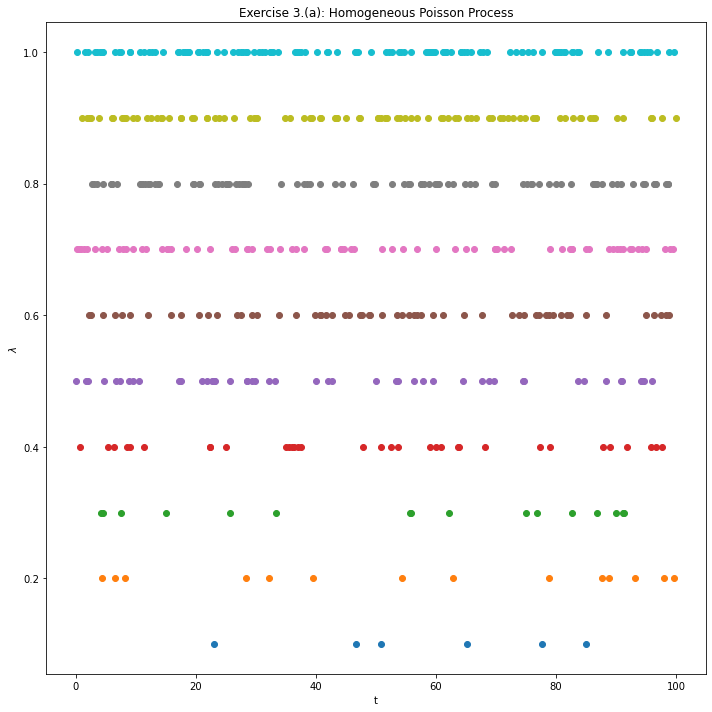

In [3]:
# test poisson_a
N=10; T=100

t_all_trials, lambdas = poisson_a(N, T)

plt.figure(figsize = (10,10))
for i_trial in range(N):
    plt.scatter(t_all_trials[i_trial], np.full(len(t_all_trials[i_trial]), lambdas[i_trial]))
    plt.xlabel('t')
    plt.ylabel('$\lambda$')
    plt.title('Exercise 3.(a): Homogeneous Poisson Process')
plt.tight_layout()

__Exercise 3.(b)__

Write a python function that simultaneously generates $N$ realizations of inhomogeneous Poisson Processes with rates $λ_1(t), ..., λ_N(t)$ within a duration $T$ and test it on $λ_m(t) = λ_0 [1 + cos(2πm t/T )]/2$ with $N = 10$, $T = 100s$ and $λ_0 = 1Hz$.

In [4]:
# function for rate density
def my_function(t, lam, m, T):
    result = (lam/2) * (1 + np.cos((2*np.pi*m*t)/T))
    return result

In [5]:
# integral of rate density
def my_integral(t, lam, m, T):
    result = ((lam/2)*t) + (((lam*T)/(4*np.pi*m)) * np.sin((2*np.pi*m/T)*t))
    return result

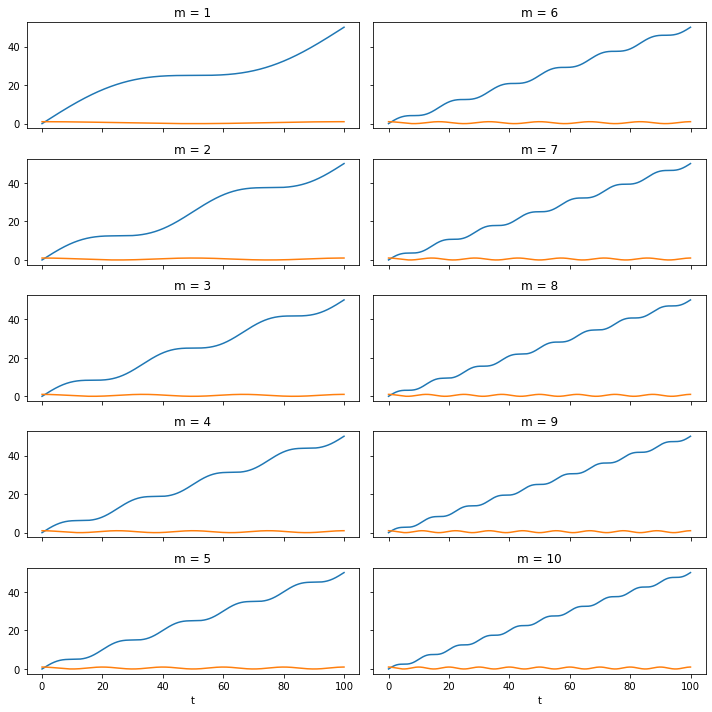

In [6]:
# plot function and integrated function
N = 10
T = 100
lam_0 = 1
t = np.linspace(0, T, 10000)

fig, ax = plt.subplots(N//2, 2, sharex = 'all', sharey = 'all', figsize = (10, 10))
for i in range(N):
    m = i+1
    y_int = my_integral(t, lam_0, m, T)
    y_func = my_function(t, lam_0, m, T)
    if m <= N//2:
        ax[i%(N//2), 0].plot(t, y_int)
        ax[i%(N//2), 0].plot(t, y_func)
        ax[i%(N//2), 0].set_title('m = {}'.format(m))
    else:
        ax[i%(N//2), 1].plot(t, y_int)
        ax[i%(N//2), 1].plot(t, y_func)
        ax[i%(N//2), 1].set_title('m = {}'.format(m))
    if m == N//2:
        ax[i%(N//2), 0].set_xlabel('t')
        ax[i%(N//2), 1].set_xlabel('t')
plt.tight_layout()

$$− ln(1 − u) = \int_0^t dt′λ(t′)$$

In [7]:
def poission_b_analytical(N, T, lam_0, ts = 0.1):
    t_all_trials = []

    for i_trial in range(N):
        left_expression = np.nan # initialize left expression of equation
        m = i_trial + 1
        t_trial = [0]
        
        t = 0 # t starts at 0
        right_expression = 0 # right expression starts at 0
        
        while t_trial[-1] <= T:
            u = np.random.rand()

            if np.isnan(left_expression):
                left_expression = -np.log(1-u) # first random number that is been drawn
            else:
                left_expression += -np.log(1-u) # further random numbers are added up

            while left_expression > right_expression: # integrate function until left_expression <= right_expression
                right_expression = my_integral(t, lam_0, m, T) # use analytically solved integral
                
                if left_expression > right_expression: # add time step only if left_expression > right_expression (will be used in next iteration)
                    t += ts

            if t > T:
                break
            else:
                t_trial.append(t)
                
        t_trial.pop(0)
        t_all_trials.append(t_trial)
    return t_all_trials

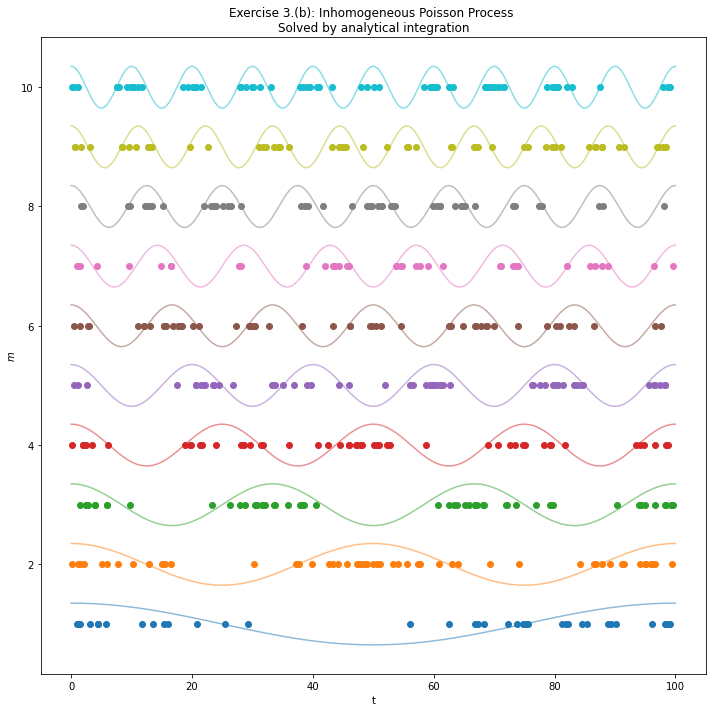

In [8]:
# test poisson_b_analytical
N=10; T=100; lam_0=1

t_all_trials = poission_b_analytical(N, T, lam_0)

plt.figure(figsize = (10,10))
t = np.linspace(0, T, 10000)
for i_trial in range(N):
    m = i_trial+1
    y_func = my_function(t, lam_0, m, T)
    y_normal = ((y_func - np.mean(y_func)) / (max(y_func) - min(y_func)) * 0.7) + m
    plt.scatter(t_all_trials[i_trial], np.full(len(t_all_trials[i_trial]), i_trial + 1))
    plt.plot(t, y_normal, alpha = 0.5)
    plt.xlabel('t')
    plt.ylabel('$m$')
    plt.title('Exercise 3.(b): Inhomogeneous Poisson Process \nSolved by analytical integration')
plt.tight_layout()

In [9]:
# test poisson_b_numerical
def poission_b_numerical(N, T, lam_0, ts = 0.1):
    t_all_trials = []

    for i_trial in range(N):
        left_expression = np.nan
        m = i_trial + 1
        t_trial = [0]

        t = 0
        right_expression = 0
        
        while t_trial[-1] <= T:
            u = np.random.rand()

            if np.isnan(left_expression):
                left_expression = -np.log(1-u)
            else:
                left_expression += -np.log(1-u)

            while left_expression > right_expression:
                f = lambda x: my_function(x, lam_0, m, T) # specifiy function arguments of current trial
                [right_expression, precision] = scipy.integrate.quad(f, 0, t) # numerical integration using scipy.integrate module
                
                if left_expression > right_expression:
                    t += ts

            if t > T:
                break
            else:
                t_trial.append(t)
        t_trial.pop(0)
        t_all_trials.append(t_trial)
    return t_all_trials

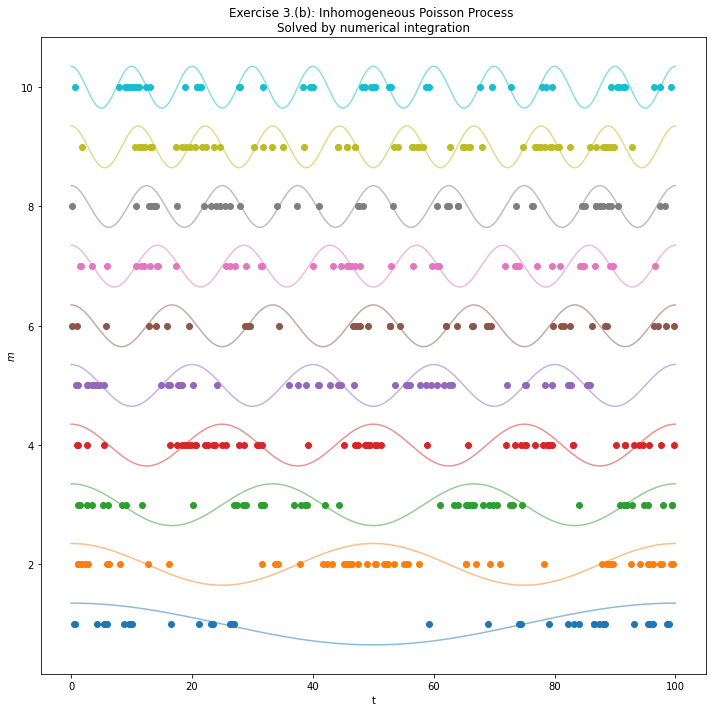

In [10]:
# test poisson_b_numerical
N=10; T=100; lam_0=1

t_all_trials = poission_b_numerical(N, T, lam_0)

plt.figure(figsize = (10,10))
t = np.linspace(0, T, 10000)
for i_trial in range(N):
    m = i_trial+1
    y_func = my_function(t, lam_0, m, T)
    y_normal = ((y_func - np.mean(y_func)) / (max(y_func) - min(y_func)) * 0.7) + m
    plt.scatter(t_all_trials[i_trial], np.full(len(t_all_trials[i_trial]), i_trial + 1))
    plt.plot(t, y_normal, alpha = 0.5)
    plt.xlabel('t')
    plt.ylabel('$m$')
    plt.title('Exercise 3.(b): Inhomogeneous Poisson Process \nSolved by numerical integration')
plt.tight_layout()

__Exercise 3.(c)__

Write a python function that simultaneously generates $N$ realizations of homogeneous Poisson
Processes with refractory periods $τ_1, ..., τ_N$ within a duration $T$. Test the function for a $N = 5$
processes with homogenous rate of $10 Hz$ within $T = 50s$ and
$τ_m = 2^{m−1} ms$.

In [11]:
def poisson_c(N, Lam, T, tau_m):
    t_all_trials = []
    
    for i_trial in range(N):
        t_trial = [0]
        tau = tau_m[i_trial]
        
        while t_trial[-1] <= T:
            u = np.random.rand()
            ISI = -np.log(1-u) / lam
            
            if t_trial[-1] + ISI + tau > T:
                break
            else:
                t_trial.append(t_trial[-1] + ISI + tau) # for each ISI, also add refractory period
                
        t_trial.pop(0)
        t_all_trials.append(t_trial)
        
    return t_all_trials

In [12]:
def my_tau(m):
    tau = (2 ** (m-1)) / 1000
    return tau

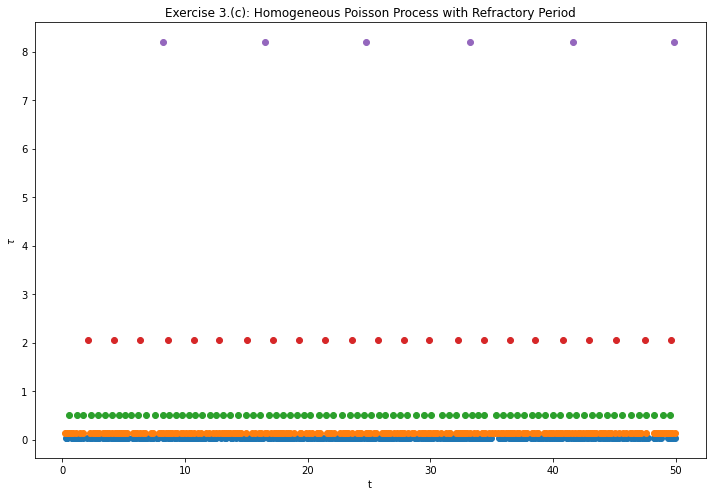

In [13]:
N = 5; lam = 10; T = 50
m = np.linspace(6, 14, N)
tau_m = my_tau(m)

t_all_trials = poisson_c(N, lam, T, tau_m)

plt.figure(figsize = (10,7))
for i_trial in range(N):
    plt.scatter(t_all_trials[i_trial], np.full(len(t_all_trials[i_trial]), tau_m[i_trial]))
    plt.xlabel('t')
    plt.ylabel('$\\tau$')
    plt.title('Exercise 3.(c): Homogeneous Poisson Process with Refractory Period')
plt.tight_layout()

Plot the autocorrelation functions (use numpy correlate) of the $N = 5$ processes.

In [14]:
def autocorr(spike_train):
    result = np.correlate(spike_train, spike_train, mode='full')
    return result

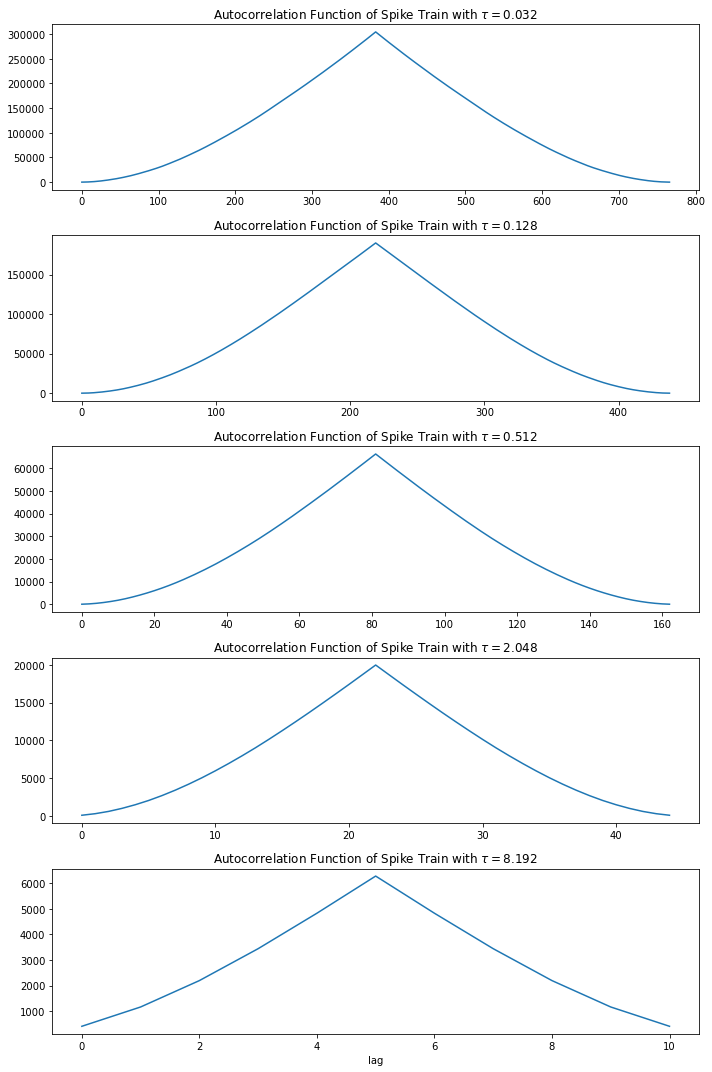

In [15]:
fig, ax = plt.subplots(N, 1, figsize = (10, 15))

autocorrs = []
for i in range(N):
    autocorrs += [autocorr(t_all_trials[i])]
    ax[i].plot(autocorrs[i])
    ax[i].set_title('Autocorrelation Function of Spike Train with $\\tau = {}$'.format(tau_m[i]))
    if i == N-1:
        ax[i].set_xlabel('lag')
plt.tight_layout()

Note: The autocorrelation functions peak at ${lag} = 0$.